# Part 1: Data Acquisition

In [4]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import time
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model

In [6]:
ranks = []
titleLengths = []
ages = []
numPoints = []
numComments = []

def scrapeHacker():
    
    for x in range(1,6):
        url = f"https://news.ycombinator.com/news?p={x}"
        time.sleep(1)
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")
        
        articleRankTitle = soup.find_all("tr", class_="athing")
        articleAgePtsComms = soup.find_all("td", class_="subtext")
        
        for data in articleRankTitle:
            rank = data.find("span", class_='rank').text.strip(".")
            ranks.append(int(rank))
            
            titleLength = len(data.find("span", class_='titleline').text.strip())
            titleLengths.append(int(titleLength))
            
        for data in articleAgePtsComms:
            age = data.find("span", class_='age').text.strip(' ago')
            pts = data.find("span", class_='score')
            comments = data.find_all("a", href=lambda href: href and "item?id" in href)[-1]

            # get age
            if "minute" in age:
                age = age.replace("minutes", "").replace("minute", "")
                ages.append(int(age)/60)
            elif "day" in age:
                age = age.replace("days", "").replace("day", "")
                ages.append(int(age)*24)
            else:
                age = age.replace("hours", "").replace("hour", "")
                ages.append(int(age))
        
            # get points
            if pts is None:
                numPoints.append(0)
            else:
                pts = pts.text.replace("points", "").replace("point", "")
                numPoints.append(int(pts))
            
            # get comments
            if "comment" not in comments.text:
                numComments.append(0)
            else:
                comments = comments.text.replace("comments", "").replace("comment", "")
                numComments.append(int(comments))
scrapeHacker()      


# create data frame from data
dataframe = pd.DataFrame({'Rank': ranks, "TitleLength": titleLengths, "AgeInHours": ages, "Points": numPoints, "NumberOfComments": numComments})
# save data frame to a file
dataframe.to_csv("hackerNews.csv", index=False)

# Part 2: Regression

In [7]:
myDF = pd.read_csv("hackerNews.csv")
myDF

,Rank,TitleLength,AgeInHours,Points,NumberOfComments
0,1,60,1,76,42
1,2,42,5,58,21
2,3,67,14,281,66
3,4,40,6,57,37
4,5,57,10,114,29
...,...,...,...,...,...
145,146,77,24,7,2
146,147,48,22,4,2
147,148,71,13,8,1
148,149,48,13,9,1


                            OLS Regression Results                            
Dep. Variable:                   Rank   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     24.60
Date:                Fri, 05 Jul 2024   Prob (F-statistic):           6.09e-10
Time:                        02:25:26   Log-Likelihood:                -756.41
No. Observations:                 150   AIC:                             1519.
Df Residuals:                     147   BIC:                             1528.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     47.8393      5.436      8.800      0.0

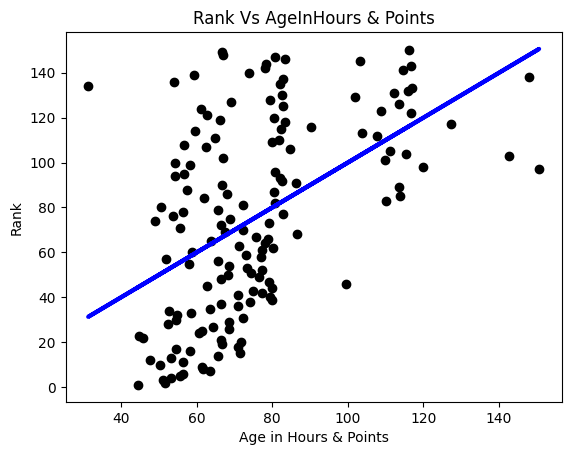

In [8]:
# Model 1: Rank Vs AgeInHours & Points

agePointResult = smf.ols('Rank ~ AgeInHours + Points', data=myDF).fit()
print(agePointResult.summary()) 
par = agePointResult.params
print(par)

# combine age and points
myDF['AgeAndPoints'] = par['Intercept'] + par['AgeInHours'] * myDF['AgeInHours'] + par['Points'] * myDF['Points']
plt.scatter( x=myDF['AgeAndPoints'],y=myDF['Rank'], c='k')
plt.plot( myDF['AgeAndPoints'], agePointResult.predict(), color='blue', linewidth=3 )

_ = plt.xlabel( 'Age in Hours & Points' )
_ = plt.ylabel( 'Rank' )
_ = plt.title("Rank Vs AgeInHours & Points")

                            OLS Regression Results                            
Dep. Variable:                   Rank   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     20.38
Date:                Fri, 05 Jul 2024   Prob (F-statistic):           1.54e-08
Time:                        02:25:43   Log-Likelihood:                -759.71
No. Observations:                 150   AIC:                             1525.
Df Residuals:                     147   BIC:                             1534.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           49.0366      5.559  

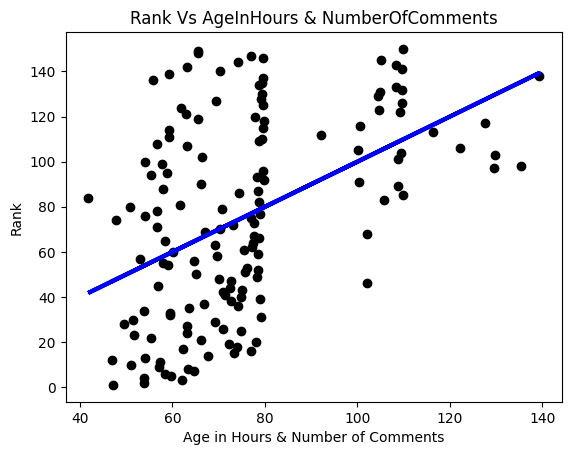

In [9]:

# Model 2: Rank Vs AgeInHours & NumberOfComments

ageCommentResult = smf.ols('Rank ~ AgeInHours + NumberOfComments', data=myDF).fit()
print(ageCommentResult.summary()) 
par = ageCommentResult.params
print(par)

# combine age and points
myDF['AgeAndComments'] = par['Intercept'] + par['AgeInHours'] * myDF['AgeInHours'] + par['NumberOfComments'] * myDF['NumberOfComments']
plt.scatter( x=myDF['AgeAndComments'],y=myDF['Rank'], c='k')
plt.plot( myDF['AgeAndComments'], ageCommentResult.predict(), color='blue', linewidth=3 )

_ = plt.xlabel( 'Age in Hours & Number of Comments' )
_ = plt.ylabel( 'Rank' )
_ = plt.title("Rank Vs AgeInHours & NumberOfComments")

                            OLS Regression Results                            
Dep. Variable:                   Rank   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     18.80
Date:                Sat, 06 Jul 2024   Prob (F-statistic):           5.36e-08
Time:                        12:09:18   Log-Likelihood:                -760.98
No. Observations:                 150   AIC:                             1528.
Df Residuals:                     147   BIC:                             1537.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      28.7842     12.367      2.328      

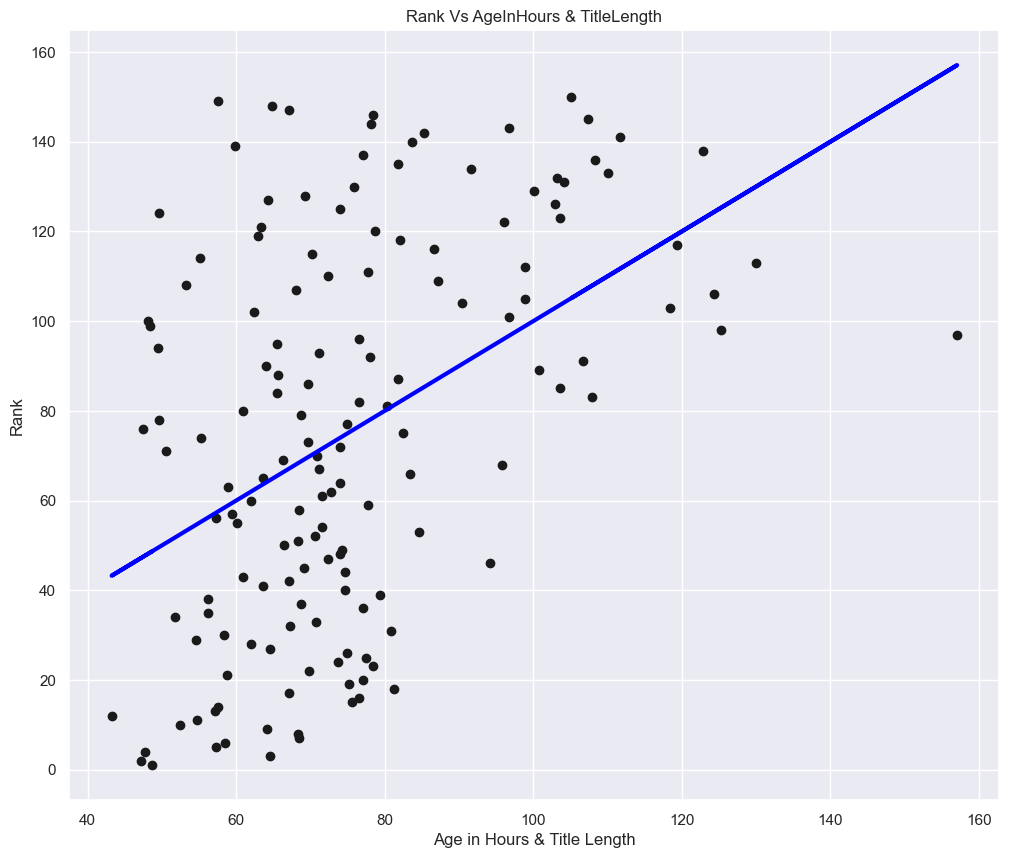

In [13]:
# Model 3: Rank Vs AgeInHours & TitleLength

ageTitleResult = smf.ols('Rank ~ AgeInHours + TitleLength', data=myDF).fit()
print(ageTitleResult.summary()) 
par = ageTitleResult.params
print(par)

# combine age and points
myDF['AgeAndTitle'] = par['Intercept'] + par['AgeInHours'] * myDF['AgeInHours'] + par['TitleLength'] * myDF['TitleLength']
plt.scatter( x=myDF['AgeAndTitle'],y=myDF['Rank'], c='k')
plt.plot( myDF['AgeAndTitle'], ageTitleResult.predict(), color='blue', linewidth=3 )

_ = plt.xlabel( 'Age in Hours & Title Length' )
_ = plt.ylabel( 'Rank' )
_ = plt.title("Rank Vs AgeInHours & TitleLength")




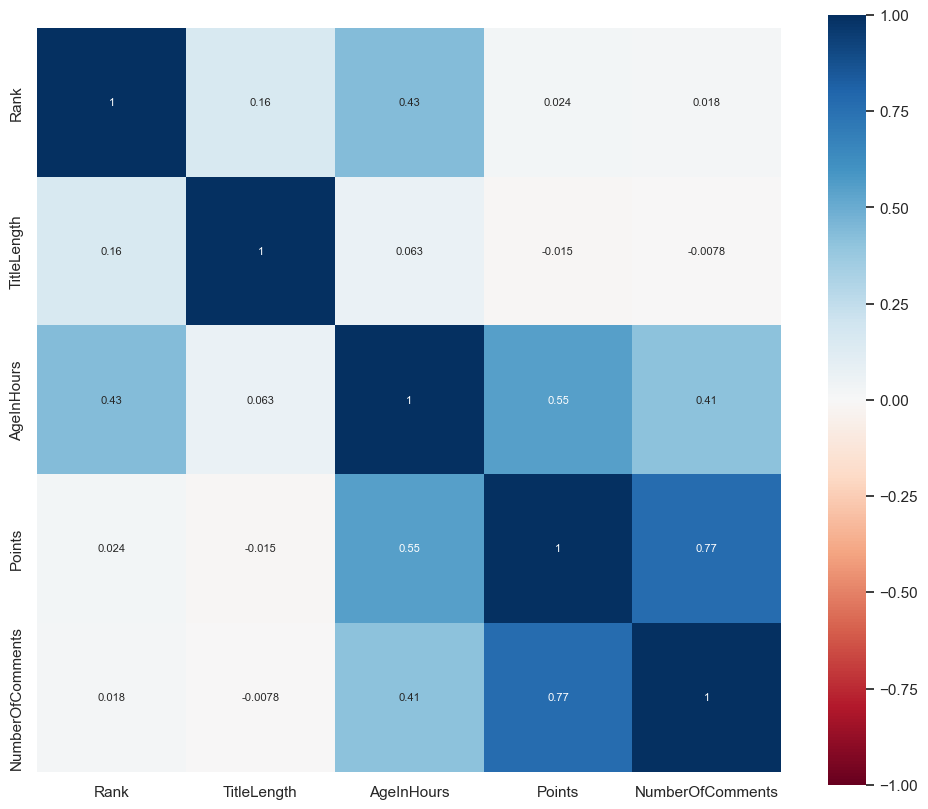

In [11]:
myDFsubSet = myDF[['Rank', 'TitleLength', 'AgeInHours', 'Points', 'NumberOfComments']]
sns.set(rc = {'figure.figsize':(12, 10)})
heatmap = sns.heatmap(myDFsubSet.corr(), cmap='RdBu', vmin=-1, vmax=1, annot=True, annot_kws={'fontsize':8, 'fontweight':'normal'},square=True)

                            OLS Regression Results                            
Dep. Variable:                   Rank   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     12.03
Date:                Sat, 06 Jul 2024   Prob (F-statistic):           0.000686
Time:                        12:09:26   Log-Likelihood:                -772.20
No. Observations:                 150   AIC:                             1548.
Df Residuals:                     148   BIC:                             1554.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        84.2211      4.247     19.829

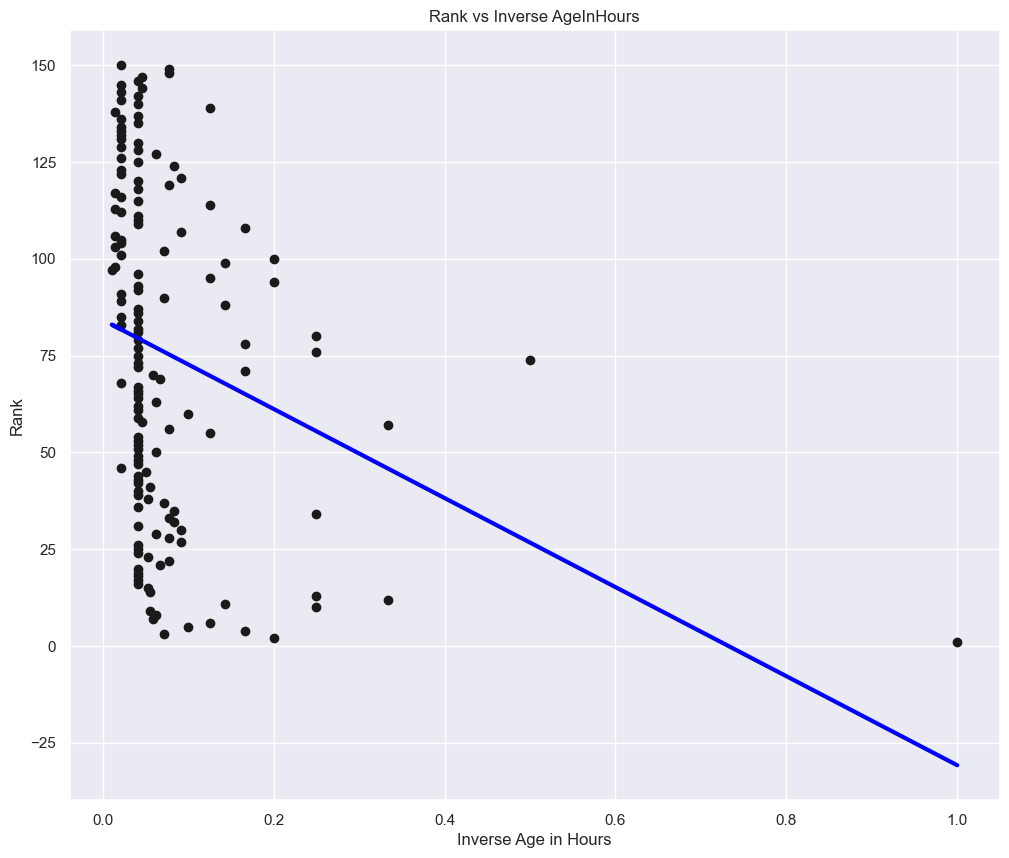

In [14]:
# Add the inverse of AgeInHours to the dataframe
myDF['InvAgeInHours'] = 1 / myDF['AgeInHours']

# Fit the model
invAgeResult = smf.ols('Rank ~ InvAgeInHours', data=myDF).fit()
print(invAgeResult.summary())

# Plot the results
plt.scatter(x=myDF['InvAgeInHours'], y=myDF['Rank'], c='k')
plt.plot(myDF['InvAgeInHours'], invAgeResult.predict(), color='blue', linewidth=3)
plt.xlabel('Inverse Age in Hours')
plt.ylabel('Rank')
plt.title('Rank vs Inverse AgeInHours')
plt.show()


Include at least 3 different regressions. Compare/contrast them. Which is the most useful. Are there linear relationships between any of the variables? How about other relationships like inverse linear (1/x)?

Among Rank Vs AgeInHours & TitleLength, Rank Vs AgeInHours & Points and Rank Vs AgeInHours & NumberOfComments, Rank Vs AgeInHours & Points is the most useful regression as it has the largest R-squared value of 0.340. There are lineral correlations between Points and AgeInHours，Points and NumberOfComments, NumberOfComments and AgeInHours, and Rank and AgeInHours. There is no linear correlation found in inverse linear regression.



# Part 3 Classification

In [15]:
#transform the rank variable into an indicator variable (1 for front page, 0 for not)
def frontToNum(x):
    if x <= 30:
        return 1
    else: 
        return 0

myDF[ "Rank" ] = myDF[ "Rank" ].apply( frontToNum )
myDF

,Rank,TitleLength,AgeInHours,Points,NumberOfComments,AgeAndPoints,AgeAndComments,AgeAndTitle,InvAgeInHours
0,1,60,1,76,42,44.539423,47.168599,48.611259,1.000000
1,1,42,5,58,21,51.678651,53.870278,47.232123,0.200000
2,1,67,14,281,66,51.098141,62.031027,64.613698,0.071429
3,1,40,6,57,37,53.242384,53.952114,47.669195,0.166667
4,1,57,10,114,29,55.644295,59.678894,57.236045,0.100000
...,...,...,...,...,...,...,...,...,...
145,0,77,24,7,2,83.410822,79.647634,78.366693,0.041667
146,0,48,22,4,2,80.599178,77.084212,67.172048,0.045455
147,0,71,13,8,1,66.841408,65.623808,64.802111,0.076923
148,0,48,13,9,1,66.778244,65.623808,57.609034,0.076923


In [16]:
model = smf.logit( formula="Rank ~ AgeAndPoints", data=myDF ).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.375094
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   Rank   No. Observations:                  150
Model:                          Logit   Df Residuals:                      148
Method:                           MLE   Df Model:                            1
Date:                Sat, 06 Jul 2024   Pseudo R-squ.:                  0.2504
Time:                        12:11:12   Log-Likelihood:                -56.264
converged:                       True   LL-Null:                       -75.060
Covariance Type:            nonrobust   LLR p-value:                 8.718e-10
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        5.7234      1.500      3.815      0.000       2.783       8.664
AgeAndPoints    -0.1071      0.024     -4.476      0.000      -0.154      -0.060
================================================================================
"""

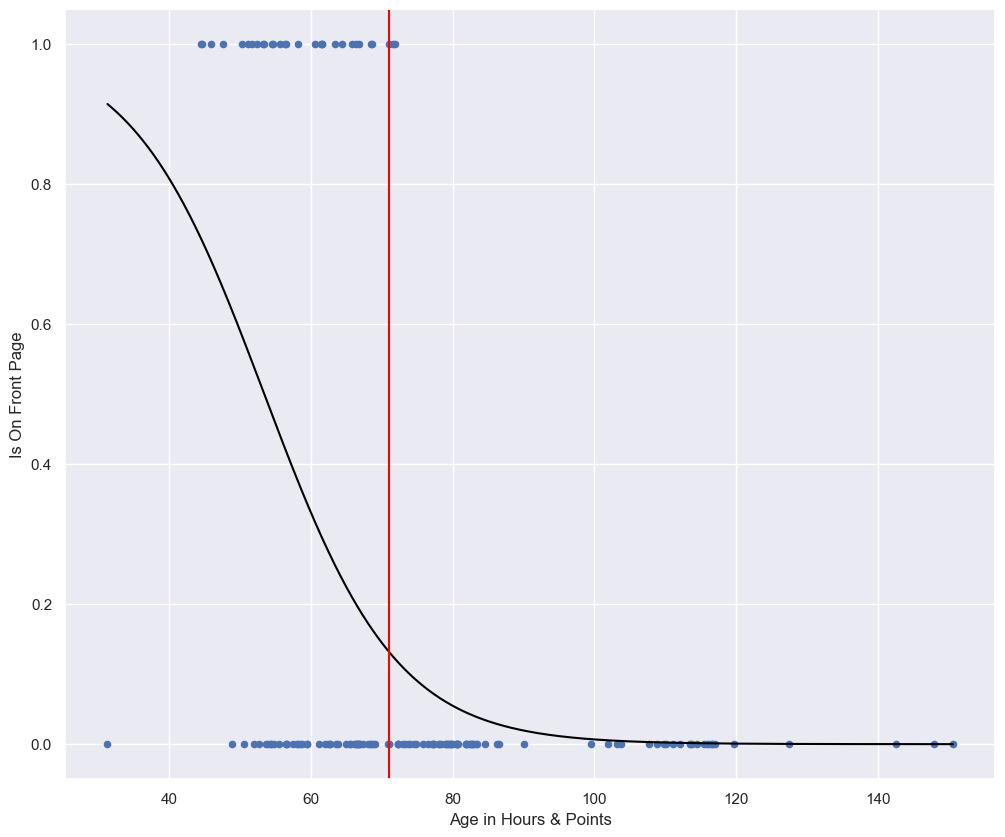

In [17]:
logistic = lambda x: 1 / ( 1 + np.exp(-x) )
myDF.plot.scatter( x='AgeAndPoints', y='Rank')


xs = np.linspace( myDF['AgeAndPoints'].min(), myDF['AgeAndPoints'].max(), 1000 )

par = dict( model.params )
par
_ = plt.plot( xs, logistic( par['Intercept'] + par['AgeAndPoints']*xs) , color='Black' )

_ = plt.xlabel( 'Age in Hours & Points' )
_ = plt.ylabel( 'Is On Front Page' )

plt.axvline(x = myDF['AgeAndPoints'].median(), color = 'red', label = 'axvline - full height')
# plt.show()

In [18]:
model2 = smf.logit( formula="Rank ~ AgeInHours", data=myDF ).fit()
model2.summary()

Optimization terminated successfully.
         Current function value: 0.437291
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   Rank   No. Observations:                  150
Model:                          Logit   Df Residuals:                      148
Method:                           MLE   Df Model:                            1
Date:                Sat, 06 Jul 2024   Pseudo R-squ.:                  0.1261
Time:                        12:11:38   Log-Likelihood:                -65.594
converged:                       True   LL-Null:                       -75.060
Covariance Type:            nonrobust   LLR p-value:                 1.354e-05
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1649      0.428      0.385      0.700      -0.674       1.004
AgeInHours    -0.0788      0.023     -3.475      0.001      -0.123      -0.034
==============================================================================
"""

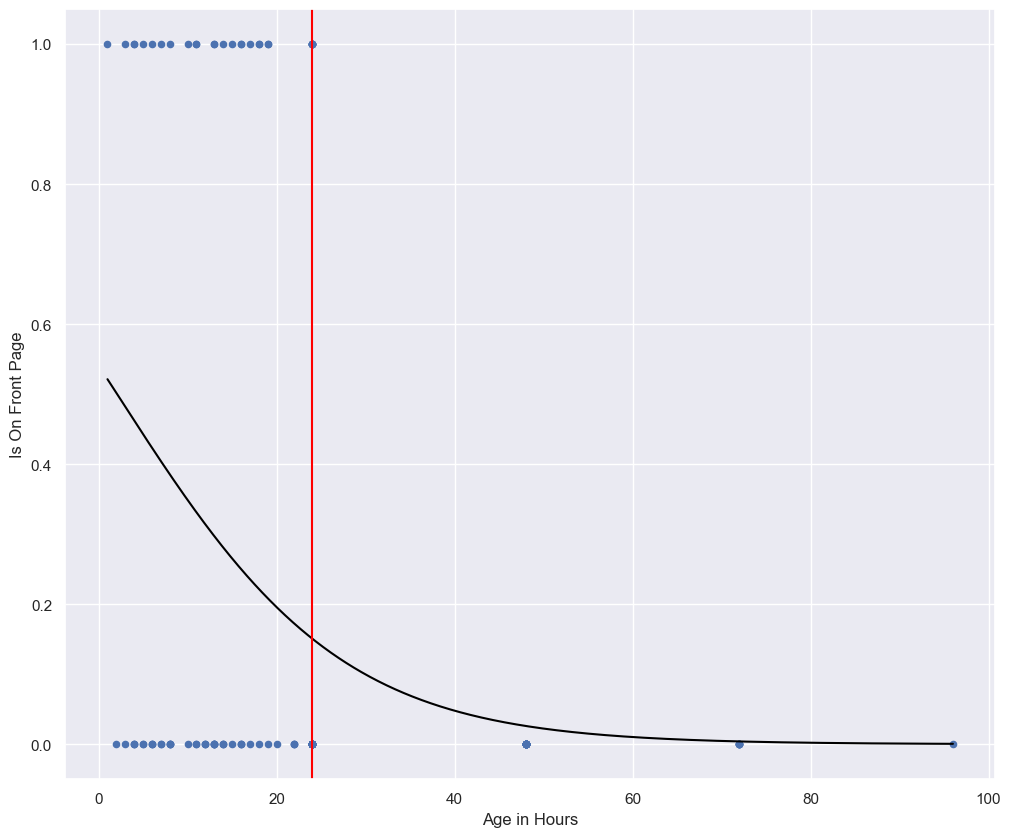

In [19]:
myDF.plot.scatter( x='AgeInHours', y='Rank')


xs = np.linspace( myDF['AgeInHours'].min(), myDF['AgeInHours'].max(), 1000 )

par = dict( model2.params )
par
_ = plt.plot( xs, logistic( par['Intercept'] + par['AgeInHours']*xs) , color='Black' )

_ = plt.xlabel( 'Age in Hours' )
_ = plt.ylabel( 'Is On Front Page' )

plt.axvline(x = myDF['AgeInHours'].median(), color = 'red', label = 'axvline - full height')

What do your regressions tell you about making the front page?

Fron the  Age in Hours & Points plot, we can see that The probability of being on the front page decreases as the combined value of age in hours and points increases. This indicates that Posts that are newer and have higher points are more likely to be on the front page.

From the Age in Hours plot, we can see that The probability of being on the front page decreases as the age in hours increases. This indicates that newer posts are more likely to be on the front page.